# Results condition-average MVPA

One of the reviewers suggested to apply MVPA on condition-average patterns instead of single-trial patterns,
as the reviewer reasonably argued that single-trial patterns (i.e. beta-weights or corresponding t-values) are
difficult to estimate in experimental designs with short interstimulus intervals, like ours (we implemented an ISI of 2 seconds for both the self- and other-task). A previous study indeed found that longer ISIs in MVPA-type analyses improve sensitivity (e.g. [Visser, de Haan, Beemsterboer, Haver, Kindt, & Scholte, 2016](http://onlinelibrary.wiley.com/doi/10.1111/psyp.12665/abstract)). However, while sensitivity is clearly reduced, it has also been shown that short ISIs do not introduce bias *given that the stimulus-presentation is fully randomized for each subject* (see [Mumford, Davis, & Poldrack, 2014](http://www.sciencedirect.com/science/article/pii/S105381191400768X)).

To follow up on the reviewer's advice, we performed between-subject MVPA using condition-average patterns of t-values of each subject. This amounted to a samples x features matrix of shape 120 x 269241 for the self-data (120 = 20 subjects * 3 conditions [act, int, sit] * 2 runs), and a sample x features matrix of shape 90 x 269241 for the other-data (90 = 20 subjects * 3 conditions). The 269241 features, here, refer to all gray-matter voxels in MNI152 (2mm) space. The actual analysis-scripts are archived in the Shared States Github-repository, in the 'extra analyses' directory: https://github.com/lukassnoek/SharedStates/tree/master/ANALYSES/EXTRA_ANALYSES. 

Note that the these analyses depend on a newer version of the *skbold* package than the original analyses; this code should be compatible with the current state of the master branch. (The skbold-code used for the original main analyses can be checked out on the *SharedStates* branch on Github!). 

In [63]:
from __future__ import division
import os
import os.path as op
import numpy as np
import nibabel as nib
from glob import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import cPickle
%matplotlib inline

Note: the 'reverse' analyses (i.e. MVPA on the other-data and cross-decoding from other-to-self), which were requested by another reviewer, are reported here for completeness as well.

In [64]:
base_dir = '/media/lukas/data/SharedStates/RESULTS/MVPA/Validation/Condition_average_mvpa/'
self_dir = op.join(base_dir, 'self')
other_dir = op.join(base_dir, 'other')
so_dir = op.join(base_dir, 'self>>other')
os_dir = op.join(base_dir, 'other>>self')
plot_dir = '/media/lukas/data/SharedStates/ARTICLE/Plots'

## Self-analysis

In [65]:
self_obs = np.load(op.join(self_dir, 'confmat.npy')).sum(axis=0)
self_obs = {'precision': self_obs / self_obs.sum(axis=0),
            'recall': self_obs / self_obs.sum(axis=1)}

In [66]:
self_perms = glob(op.join(self_dir, 'permutations', '*', '*.npy'))

self_cm = np.zeros((len(self_perms), 3, 3))
for i, sfile in enumerate(self_perms):
    
    self_cm[i, :, :] = np.load(sfile).sum(axis=0)

In [60]:
self_perms = {'recall': self_cm / self_cm.sum(axis=2)[:, np.newaxis],
              'precision': self_cm / self_cm.sum(axis=1)[:, np.newaxis]}

(1000, 3, 3)

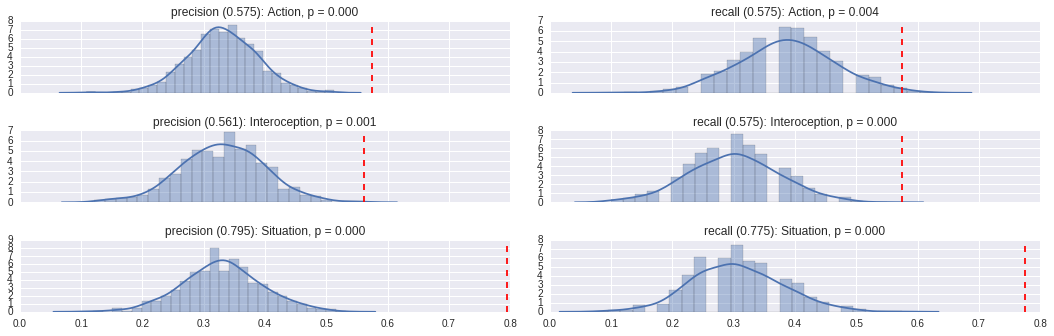

In [7]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(15, 5))

for i, cls in enumerate(['Action', 'Interoception', 'Situation']):
    
    for ii, metric in enumerate(['precision', 'recall']):
        perm_scores = self_perms[metric][:, i, i] 
        obs_score = self_obs[metric][i, i]
        
        p = (obs_score < perm_scores).sum() / perm_scores.shape[0]
        sns.distplot(perm_scores, ax=ax[i][ii])
        ax[i][ii].axvline(x=obs_score, color='r', linestyle='--')
        ax[i][ii].set_title('%s (%.3f): %s, p = %.3f' % (metric, obs_score, cls, p))
plt.tight_layout(pad=2)

## Self >> other

In [8]:
so_obs = np.load(op.join(so_dir, 'confmat.npy')).sum(axis=0)
so_obs = {'precision': so_obs / so_obs.sum(axis=0),
            'recall': so_obs / so_obs.sum(axis=1)}

In [9]:
so_perms = glob(op.join(so_dir, 'permutations', '*', '*.npy'))

so_cm = np.zeros((len(so_perms), 3, 3))
for i, sofile in enumerate(so_perms):
    
    so_cm[i, :, :] = np.load(sofile).sum(axis=0)

In [10]:
so_perms = {'recall': so_cm / so_cm.sum(axis=2)[:, np.newaxis],
            'precision': so_cm / so_cm.sum(axis=1)[:, np.newaxis]}

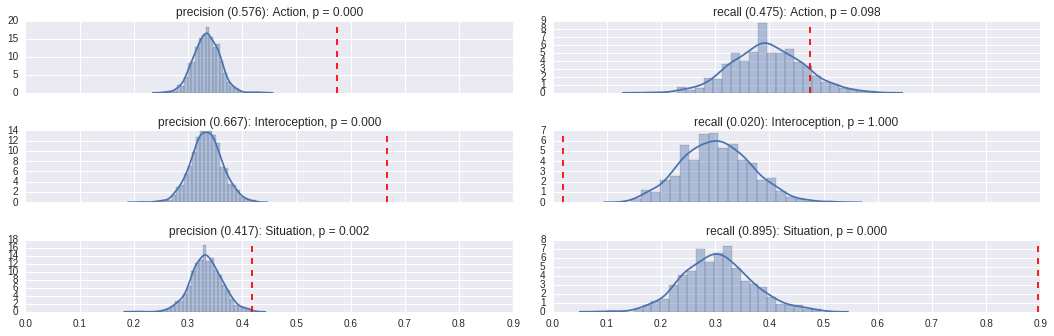

In [11]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(15, 5))

for i, cls in enumerate(['Action', 'Interoception', 'Situation']):
    
    for ii, metric in enumerate(['precision', 'recall']):
        perm_scores = so_perms[metric][:, i, i] 
        obs_score = so_obs[metric][i, i]
        p = (obs_score < perm_scores).sum() / perm_scores.shape[0]
        sns.distplot(perm_scores, ax=ax[i][ii])
        ax[i][ii].axvline(x=obs_score, color='r', linestyle='--')
        ax[i][ii].set_title('%s (%.3f): %s, p = %.3f' % (metric, obs_score, cls, p))
plt.tight_layout(pad=2)

# Plots

In [21]:
tmp = np.load(op.join(self_dir, 'confmat.npy'))
self_plotdata = {'precision': tmp / tmp.sum(axis=1)[:, np.newaxis],
                 'recall': tmp / tmp.sum(axis=2)[:, np.newaxis]}

tmp = np.load(op.join(so_dir, 'confmat.npy'))
so_plotdata = {'precision': tmp / tmp.sum(axis=1)[:, np.newaxis],
               'recall': tmp / tmp.sum(axis=2)[:, np.newaxis]}

all_data = {'Self-analysis': self_plotdata,
            'Cross-analysis': so_plotdata}

all_perms = {'Self-analysis': self_perms,
             'Cross-analysis': so_perms}

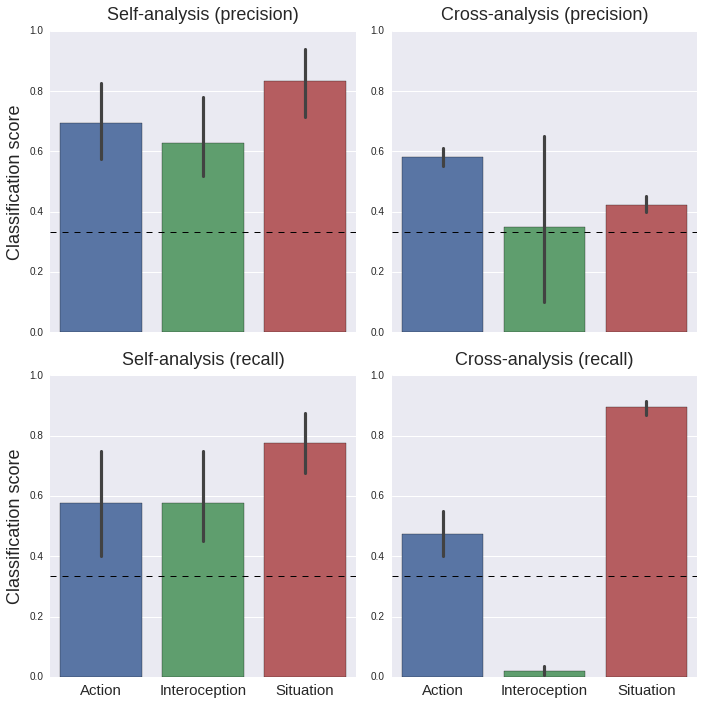

In [55]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 10))

for i, metric in enumerate(['precision', 'recall']):
    
    for ii, analysis in enumerate(['Self-analysis', 'Cross-analysis']):
        #std = all_perms[analysis][metric][:, (0, 1, 2), (0, 1, 2)].std(axis=0)
        # ^ std from permutations could also be used (but kinda confusing)
        
        data = all_data[analysis][metric][:, (0, 1, 2), (0, 1, 2)]
        data[np.isnan(data)] = 0
        sns.barplot(data=data, ax=ax[i][ii], ci=95)#, yerr=std,
                    #error_kw=dict(ecolor='black', lw=2, capsize=2, capthick=2))
        ax[i][ii].set_ylim((0, 1))
        ax[i][ii].set_title('%s (%s)' % (analysis, metric), fontsize=18, y=1.02)
        ax[i][ii].axhline(y=0.333, color='black', linestyle='--', lw=1)
        if i == 1:
            ax[i][ii].set_xticklabels(['Action', 'Interoception', 'Situation'], fontsize=15)
        
        if ii == 0:
            ax[i][ii].set_ylabel('Classification score', fontsize=18)
        
plt.tight_layout(pad=1.5)
plt.savefig(op.join(plot_dir, 'condition_average_results.png'))

## Plotting 

## Comparison single-trial & condition-average

In [42]:
# load single-trial results
self_dir = op.join('/media/lukas/data/SharedStates/RESULTS/MVPA/Validation/SELF/100000iter_results')
self_files = glob(op.join(self_dir, '*.pickle'))
s_confmat = np.zeros((len(self_files), 3, 3))
for i, f in enumerate(self_files):
    tmp = cPickle.load(open(f)).conf_mat
    s_confmat[i, :, :] = tmp

s_confmat[np.isnan(s_confmat)] = 0

In [43]:
cross_dir = op.join('/media/lukas/data/SharedStates/RESULTS/MVPA/Validation/CROSS/100000iter_results')
cross_files = glob(op.join(cross_dir, '*.pickle'))
c_confmat = np.zeros((len(cross_files), 3, 3))
for i, f in enumerate(cross_files):
    tmp = cPickle.load(open(f)).conf_mat
    c_confmat[i, :, :] = tmp

c_confmat[np.isnan(c_confmat)] = 0

In [45]:
self_st = {'precision': s_confmat / s_confmat.sum(axis=1)[:, np.newaxis],
           'recall': s_confmat / s_confmat.sum(axis=2)[:, np.newaxis]}

cross_st = {'precision': c_confmat / c_confmat.sum(axis=1)[:, np.newaxis],
            'recall': c_confmat / c_confmat.sum(axis=2)[:, np.newaxis]}

st_data = {'Self-analysis': self_st,
           'Cross-analysis': cross_st}

In [76]:
st.std()

0.21408072205491918

In [77]:
labels = ['Action', 'Interoception', 'Situation']
for i, metric in enumerate(['precision', 'recall']):
    
    for ii, analysis in enumerate(['Self-analysis', 'Cross-analysis']):
        
        for iii in range(3):
            
            st = st_data[analysis][metric][:, iii, iii]

            st[np.isnan(st)] = 0
            ca = all_data[analysis][metric][:, iii, iii]
            ca[np.isnan(ca)] = 0
            t, p = stats.ttest_ind(ca, st, equal_var=False)
            print('T-test %s, %s, (%s):' % (analysis, labels[iii], metric))
            print('Mean(condition-av): %.3f (%.3f), Mean(single-trial): %.3f (%.3f)' % (ca.mean(), ca.std(), st.mean(), st.std()))
            print('t(%i) = %.3f, p = %.3f\n' % ((len(ca)-1 + len(st)-1), t, p))

T-test Self-analysis, Action, (precision):
Mean(condition-av): 0.695 (0.211), Mean(single-trial): 0.546 (0.132)
t(28) = 1.950, p = 0.074

T-test Self-analysis, Interoception, (precision):
Mean(condition-av): 0.628 (0.206), Mean(single-trial): 0.551 (0.129)
t(28) = 1.030, p = 0.323

T-test Self-analysis, Situation, (precision):
Mean(condition-av): 0.835 (0.192), Mean(single-trial): 0.670 (0.117)
t(28) = 2.370, p = 0.035

T-test Cross-analysis, Action, (precision):
Mean(condition-av): 0.582 (0.047), Mean(single-trial): 0.450 (0.214)
t(28) = 2.577, p = 0.017

T-test Cross-analysis, Interoception, (precision):
Mean(condition-av): 0.350 (0.450), Mean(single-trial): 0.441 (0.317)
t(28) = -0.545, p = 0.595

T-test Cross-analysis, Situation, (precision):
Mean(condition-av): 0.422 (0.041), Mean(single-trial): 0.441 (0.091)
t(28) = -0.771, p = 0.447

T-test Self-analysis, Action, (recall):
Mean(condition-av): 0.575 (0.275), Mean(single-trial): 0.544 (0.132)
t(28) = 0.324, p = 0.752

T-test Self-